# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [ ]:
import platform
print("Python Version: ", platform.python_version())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data

# This will show the articles read by a specific email account (the email is hashed into a unique value for comparison and privacy purposes)
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content to get an idea of the data

# Here we see Watson article detail
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
#!pip install sweetviz
# importing sweetviz
#import sweetviz as sv#analyzing the dataset
#advert_report = sv.analyze(df)#display the report
#advert_report.show_html('EDA.html')

### <font color='red'> Exploratory Data Analysis Notes </font>


While nothing particular "magical" here from a fancy numpy-scipy-python perspective, I always consider EDA to be the foundation that the rest of the solution is built on. As with anything that requires a foundation, the better the foundation, generally the better the results.

This references is a little dated, but still valid: https://www.kaggle.com/ekami66/detailed-exploratory-data-analysis-with-python

This shows some promise, an EDA package called Sweetviz. I gave it a try and does a decent job pulling together the relevant stats: https://towardsdatascience.com/sweetviz-automated-eda-in-python-a97e4cabacde


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [5]:
# Let's check who's reading what. This check will give the unique value of the number of times a user accesses an article. We don't really know if they read the article, as there is
# no mechanism cited or provided that gives this detail. But this is a good start. 

df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

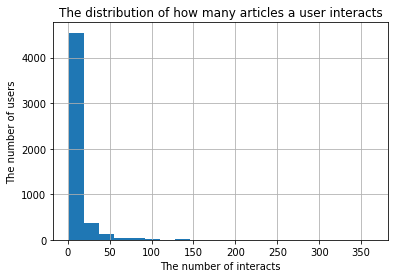

In [6]:
# The distribution of how many articles a user interacts.
df['email'].value_counts().hist(bins=20)
plt.title('The distribution of how many articles a user interacts')
plt.xlabel('The number of interacts')
plt.ylabel('The number of users')
plt.show()

In [7]:
# Here's the top user, who's interacted with 364 articles.
df.email.describe()

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object

In [8]:
# Fill in the median and maximum number of user_article interactions below
# Using "df['email'].value_counts().describe()" to get the values

median_val = 3 # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [9]:
# Find and explore duplicate articles
df_content[df_content['article_id'].duplicated()]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [10]:
df.article_id.describe()

count    45993.000000
mean       908.846477
std        486.647866
min          0.000000
25%        460.000000
50%       1151.000000
75%       1336.000000
max       1444.000000
Name: article_id, dtype: float64

In [11]:
# Remove any rows that have the same article_id - only keep the first

df_content = df_content[~df_content['article_id'].duplicated()]

In [12]:
df.article_id.describe()

count    45993.000000
mean       908.846477
std        486.647866
min          0.000000
25%        460.000000
50%       1151.000000
75%       1336.000000
max       1444.000000
Name: article_id, dtype: float64

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

#### <font color='red'>  A Quick Note: Making Blogs and Articles successful </font>


As a longtime user (and seller) of Watson Studio, I'm very familiar with the layout and the "community" concept. I'd not think of Watson Studio/Community in the traditional blog sense, but it's worth looking at similar metrics/kpi's to understand what users find valuable.

Here are some references I found useful:

https://databox.com/google-analytics-blog-post-performance  (who doesn't use Google Analytics these days?)

https://blog.hubspot.com/marketing/business-blogging-metrics-kpis-list (a little dated, but good ideas)

https://neilpatel.com/blog/7-important-metrics-track-contents-success/ (this has some good ideas on visuals that display at a glance performance metrics)

https://halftheclothes.com/how-to-measure-blog-performance-for-beginners/ (noob guide)

In [13]:
# a. The number of unique articles that have an interaction with a user. 
# A-D are stats I'd expect that IBM will monitor closely to assess topics of interest and overall site usage

df['article_id'].value_counts().describe()


count    714.000000
mean      64.415966
std      109.175923
min        1.000000
25%        8.000000
50%       25.000000
75%       69.000000
max      937.000000
Name: article_id, dtype: float64

In [14]:
# b. The number of unique articles in the dataset (whether they have any interactions or not).

len(df_content['article_id'])

1051

In [15]:
# c. The number of unique users in the dataset. (excluding null values) 
# Hash values for email obfuscation still used, we'll make that more user/readable friendly soon

df['email'].value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [16]:
# d. The number of user-article interactions in the dataset.

# This is a good metric to start, but be good to consider metrics that show not just the click, but was the article read and/or commented on

len(df)

45993

In [17]:
unique_articles = 714 # The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [18]:
# Most viewed article ID should give a view of either most popular topic for user. I say should since the title of the article potentially drives a click. However we also should 
# be aware of the concept of "clickbait"...using a compelling title to get the user to click, then not having much content.

df['article_id'].value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [19]:
most_viewed_article_id = '1429.0'  # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed how many times?

In [20]:
# Let's check out what's interesting. Also validates the Max Views

df.loc[df['article_id'] == 1429]

,article_id,title,email
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
41,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
75,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
80,1429.0,use deep learning for image classification,d385b6c44711688ce2a33eb596495bf9243e1750
...,...,...,...
45147,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45153,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45156,1429.0,use deep learning for image classification,6edb515f6b2b4fcb369b119afcc1b26d9c2f87a4
45190,1429.0,use deep learning for image classification,7aef8f14001f95da4a76c810970d4aa469cdf11f


In [21]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [22]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <font color='red'>  Rank Based Recommendation Notes</font>


In our case, we don't know whether a user liked an article or not, just the user interactions. So, interactions is really the measure of article popularity in the absence of any other ranking/rating data. For us, this means building a function that returns top "X" articles and article ID's based on the number of user interactions.

Loosely related, but eminently interesting is the page rank engine of Google: https://anvil.works/blog/search-engine-pagerank


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [23]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.title.value_counts().head(n).index)
        
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.article_id.value_counts().head(n).index)
 
    return top_articles # Return the top article ids

In [24]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [25]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <font color='red'> Collaborative Filtering Notes</font>

In the lectures, we examined two styles of Collaborative Filtering: 
1) Model Based Collaborative Filtering
2) Neighborhood Based Collaborative Filtering

We'll be using Neighborhood Based Collaborative filtering. There are two main modes here:

1) User-based collaborative filtering: In this type of recommendation, users related to the user you would like to make recommendations for are used to create a recommendation.

2) Item-based collaborative filtering: In this type of recommendation, first you need to find the items that are most related to each other item (based on similar ratings). Then you can use the ratings of an individual on those similar items to understand if a user will like the new item.

And we'll be using user based collaborative filtering. I used much of the lecture as reference material.

I read through this, some interesting thoughts especially around Cosine similarity. https://medium.com/sfu-cspmp/recommendation-systems-user-based-collaborative-filtering-using-n-nearest-neighbors-bf7361dc24e0




### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [26]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    
    # Populate the User Item matrix
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = user_item.notnull().astype(int)
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [27]:
# Look at user-article matrix
user_item

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [29]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    sim_dict = dict()
    
    # compute similarity of each user to the provided user
    
    # Use dot function to here, there are a variety of other methods (Cosine, etc.)
    n_users = user_item.shape[0]
    for uid in range(1, n_users):
        sim_dict[uid] = np.dot(user_item.loc[user_id], user_item.loc[uid])

    # sort by the similarity
    sim_dict = sorted(sim_dict.items(), key=lambda x: x[1], reverse=True)

    # List of ID's
    most_similar_users = [pair[0] for pair in sim_dict]
   
    # Take out own user's id
    most_similar_users = [uid for uid in most_similar_users if uid != user_id]
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [30]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [31]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    
    # Get list of article names here, ID's below
    
    article_names = list(set(df[df['article_id'].isin(article_ids)]['title']))
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.loc[user_id]
    article_ids =  [str(aid) for aid in article_ids[article_ids == 1].index]
    
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    
    # Find the similar users here and get 10 recommendations
    user_ids = find_similar_users(user_id)
    
    recs = df[df['user_id'].isin(user_ids)]['article_id']
    
    recs = list(set(recs))
    
    return recs[:m] # return your recommendations for this user_id    

In [32]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['data science bowl 2017',
 'the greatest public datasets for ai – startup grind',
 'higher-order logistic regression for large datasets',
 'analyze ny restaurant data using spark in dsx',
 'apache spark™ 2.0: extend structured streaming for spark ml',
 'timeseries data analysis of iot events by using jupyter notebook',
 'this week in data science (april 18, 2017)',
 '3992    using apache spark to predict attack vectors a...\nName: title, dtype: object',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'detect malfunctioning iot sensors with streaming analytics']

In [33]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [34]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    
    # User - item interactions
    user_int = df.groupby(['user_id'])['article_id'].count()
    
    # Number of users here
    n_users = user_item.shape[0]
    
    # Neighbor_id column
    neighbor_id = [u_id for u_id in range(1, n_users) if u_id != user_id]
    
    # Similarity and num_interactions columns
    num_interactions = []
    similarity = []
    for u_id in neighbor_id:
        num_interactions.append(user_int.loc[u_id])
        similarity.append(np.dot(user_item.loc[user_id], user_item.loc[u_id]))
        
    # Create neighbors_df dataframe
    neighbors_df = pd.DataFrame({'neighbor_id': neighbor_id, 
                                 'similarity': similarity,
                                 'num_interactions': num_interactions})
    
    #print("Here is the neighbors DF")
    #print(neighbors_df.head(20))
    
    # Sort by similarity
    neighbors_df.sort_values('similarity', ascending=False, inplace=True)
    
    #print("Here is the neighbors DF post_sort")
    #print(neighbors_df.head(20))
    
    return neighbors_df # Return the dataframe specified in the doc_string



def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    # Get neighbors
    neighbors_df = get_top_sorted_users(user_id)
    
    # Top neighbors
    top_neighbors = list(neighbors_df[:m]['neighbor_id'])

    # Articles viewed by top neighbors
    recs = []
    for u_id in top_neighbors:
        article_ids = user_item.loc[u_id]
        recs.extend([str(a_id) for a_id in article_ids[article_ids == 1].index])

    # Unique values
    recs = list(set(recs[:m]))

    # Find unique article names
    rec_names = list(set(df[df['article_id'].isin(recs)]['title']))

    return recs, rec_names

In [35]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1271.0', '89.0', '495.0', '793.0', '1053.0', '232.0', '981.0', '1186.0', '53.0', '727.0']

The top 10 recommendations for user 20 are the following article names:
['introducing streams designer', 'top 20 r machine learning and data science packages', 'super fast string matching in python', '10 powerful features on watson data platform, no coding necessary', 'connect to db2 warehouse on cloud and db2 using scala', 'access mysql with python', 'from python nested lists to multidimensional numpy arrays', 'top 10 machine learning algorithms for beginners', 'customer demographics and sales', 'self-service data preparation with ibm data refinery']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [36]:

print(get_top_sorted_users(1).head(5))

      neighbor_id  similarity  num_interactions
3931         3933          35                45
3780         3782          17               363
21             23          17               364
4457         4459          15               158
201           203          15               160


In [37]:
print(get_top_sorted_users(131).head(10))

      neighbor_id  similarity  num_interactions
3868         3870          74               144
3780         3782          39               363
22             23          38               364
4457         4459          33               158
201           203          33               160
3695         3697          29               145
3762         3764          29               169
97             98          29               170
48             49          29               147
240           242          25               148


In [38]:
### Tests with a dictionary of results

user1_most_sim = 3933 # Find the user that is most similar to user 1 
user131_10th_sim = 242 # Find the 10th most similar user to user 131

In [39]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

For a new user, I would just recommend the first N amount of articles that have the most interaction with it.
User to User filtering wouldn't be best for a new user. A new user would have no article interactions. Rank-based recommendations would be a better approach. 

I really like this approach to the cold start problem, called the Multi-Armed Bandit! At this point, I probably more like the name, but look to review the Git on this in more detail.

https://towardsdatascience.com/solving-cold-user-problem-for-recommendation-system-using-multi-armed-bandit-d36e42fe8d44

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [40]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = [str(art_id) for art_id in get_top_article_ids(10)] # Your recommendations here



In [41]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [42]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [43]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <font color='red'> Matrix Factorization Notes</font>

Using a machine learning methon for Dimension Reduction called SVD (Singular Value Decomposition), we can recommend articles for a range of users. 
SVD is useful when we have no null values in user_item_matrix. In the online lessons, we could use FunkSVD is a new method that 
is useful for matrices with missing values. 

This was a really helpful article that both gives a good dive into SVD, along with a good recap of Collaborative and Content filtering: https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/

And this article had helpful python code to build up the SVD code here: https://towardsdatascience.com/beginners-guide-to-creating-an-svd-recommender-system-1fd7326d1f65

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [44]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [45]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [46]:
# Perform SVD on the User-Item Matrix Here

#u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False) # use the built in to get the three matrices

In [47]:
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [48]:
# Get matrix shapes

u.shape, s.shape, vt.shape

((5149, 5149), (714,), (714, 714))

In [49]:
u.shape

(5149, 5149)

In [50]:
s.shape

(714,)

In [51]:
vt.shape

(714, 714)

#### Response/Explanation of Difference to Lecture


In the lectures, we had the movies example.

We had this code snipped: 
u, s, vt = np.linalg.svd(user_movie_subset)
s.shape, u.shape, vt.shape

So, same SVD function used here as in the lesson. We saw this from the 3 objects returned: 

 1. The u matrix is a square matrix with the number of rows and columns equaling the number of users. 

 2. The v transpose matrix is also a square matrix with the number of rows and columns equaling the number of items.

 3. The sigma matrix is actually returned as just an array with 4 values.  
 
The main difference between our example here with the Watson Studio articles and the Movies example in the lesson is here we have 714 latent features. 
Also, we have no null-values so SVD works fine. Otherwise, we'd need FunkSVD. 
 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

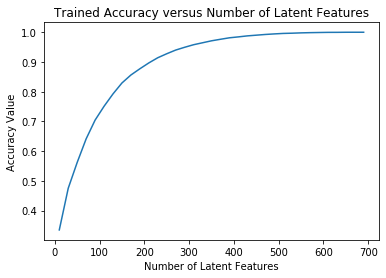

In [52]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy Value');
plt.title('Trained Accuracy versus Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [53]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)


train_idx = set(user_item_train.index)
train_arts = set(user_item_train.columns)

In [54]:
user_item_train.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# How many users can we make predictions for in the test set?
len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

20

In [56]:
# How many users in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['user_id'].unique()) - len(np.intersect1d(df_train['user_id'].unique(),df_test['user_id'].unique()))

662

In [57]:
# How many articles can we make predictions for in the test set?
len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

574

In [58]:
# How many articles in the test set are we not able to make predictions for because of the cold start problem?
len(df_test['article_id'].unique()) - len(np.intersect1d(df_train['article_id'].unique(),df_test['article_id'].unique()))

0

In [59]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, # letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many movies can we make predictions for in the test set?':b,  # letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d # letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [60]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [61]:
u_train.shape, s_train.shape, vt_train.shape

((4487, 4487), (714,), (714, 714))

In [62]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

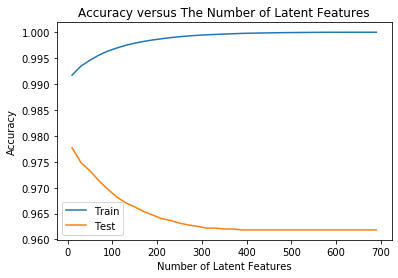

In [63]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs_test = []
sum_errs_train = []


tr_idx = user_item_train.index.isin(test_idx)
tr_arts = user_item_train.columns.isin(test_arts)
u_test = u_train[tr_idx, :]
vt_test = vt_train[:, tr_arts]



for k in num_latent_feats:
    # Build with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    s_test_new, u_test_new, vt_test_new = s_train_new, u_test[:, :k], vt_test[:k, :]
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_train_new, s_train_new), vt_train_new))
    user_item_est_test = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # The error for each prediction to actual value
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_test.loc[list(set(train_idx) & set(test_idx))], user_item_est_test)
    
    # Get the total errors
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
# Time to plot the Training and Test data

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_est_train.shape[0]*user_item_est_train.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_est_test.shape[0]*user_item_est_test.shape[1]), label='Test');

plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy versus The Number of Latent Features');
plt.legend();



`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

#### <font color='red'>  Final Comments and Conclusion </font>

The accuracy for the test is decreasing to reach 96.2% with approximately 300 latent features. Training is increasing to reach 100%. But since the test set contains only 20 users, we need more data to display more accurate results

We've looked at these types of recommendation approaches:

* Knowledge-based recommendations
* Collaborative filtering
* Matrix factorization with SVD

Note: I did skip Content-based recommendations. I did read over this approach (another project for a rainy day): https://www.analyticsvidhya.com/blog/2015/08/beginners-guide-learn-content-based-recommender-systems/  As well, the lecture exercise on Content Based Recommendation was pretty useful too. 

Potentially, to get to a point where I would confidently say "my recommendation engine" is the better approach would be to go back to the start of the lectures on experiment design and A/B testing. IMHO, for this specific problem of building a recommendation engine for the IBM Watson Community, offhand I would say User Interaction is a good start. The user community is fairly specific (data scientists, people interested in computer science and programming, Watson users), and provided the article titles and abstracts are written decently well, users will be attracted to areas specific to their community. For example, if someone wrote an article on "How to change the oil in a Honda motorcycle" and posted it, I would neither expect this to be a popular article nor one that would be recommended by any engine. Possibly that might be a good test of the recommendation engine to see if it DID recommend that article! :-)

I would look to incorporate some type of feedback system to determine if the recommendation engine I built was actually recommending better than the baseline of no recommendations given. This could be accomplished by getting feedback at the end of an article recommended, i.e. querying the user "Was this recommended article useful to you?". Or look for a set of volunteers (maybe offer a month free of Watson time) to allow A/B testing against the baseline system to the new ones. 

When I started this series of lectures (BTW which I enjoyed quite a bit), I first thought of Amazon which to me has basically two recommentation engines. The first is "Users that bought the same item(s) as the one(s) you just purchased looked at this". The second are the reviews for given products. Personally, I generally skip the first, which is the actual recommendation engine. I find that Amazon, in spite of how much I use it, and how much the know about me and my purchaes, has a pretty average recommendation system. 

Throughout these lectures, I found that there is much more to recommendation engines than I realized. As an IBM'er, I'm looking forward to actually using Watson to build a recommendation engine. Here's the walkthrough: https://developer.ibm.com/technologies/data-science/patterns/build-a-product-recommendation-engine-with-watson-machine-learning/

Thanks!